## Imports

In [ ]:
# !pip install datasets
!pip install keras-tuner

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import LambdaCallback

from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB5
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

import keras_tuner as kt

## Data preparation and visualisation

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


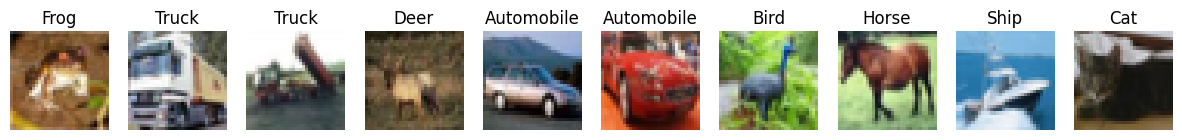

In [2]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Visualize some samples
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
fig, axes = plt.subplots(1, 10, figsize=(15, 15))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i])
    ax.set_title(class_names[y_train[i][0]])
    ax.axis('off')
plt.show()


## Model implementations

### Simple CNN (3 conv. layers)

In [ ]:
def simple_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

simple_cnn = simple_cnn()
simple_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Custom-built ResNet50

In [4]:
def custom_resnet50():
    base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))

    # Add additional layers after the base model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),  # Additional dense layer for complexity
        layers.Dropout(0.5),  # Dropout to reduce overfitting
        layers.Dense(128, activation='relu'),  # Another dense layer for added complexity
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')  # Output layer
    ])

    return model

resnet50 = custom_resnet50()
resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### DenseNet-121 (Keras Tuner)

In [ ]:
def model_builder(hp):
    hp_units = hp.Int('units', min_value=16, max_value=64, step=16)
    base_model = DenseNet121(weights=None, include_top=False, input_shape=(32, 32, 3))
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(hp_units, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(model_builder, objective='val_accuracy', max_trials=3, directory='densenet_tuning')

Reloading Tuner from densenet_tuning/untitled_project/tuner0.json


### Custom-built EfficientNet-B5

In [ ]:
def custom_efficientnet_b5():
    base_model = EfficientNetB5(weights=None, include_top=False, input_shape=(32, 32, 3))
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(10, activation='softmax')
    ])
    return model

efficientnet_b5 = custom_efficientnet_b5()
efficientnet_b5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Training (with checkpointing and early stopping)



In [6]:
# Define the ModelCheckpoint callback
checkpoint_callback = lambda model_name: ModelCheckpoint(
    filepath=f"{model_name}_best_model.keras",  # Save path for the best model
    monitor="val_loss",  # Monitor validation loss
    save_best_only=True,  # Only save the best model
    save_weights_only=False,  # Save the whole model, not just weights
    verbose=1
)

In [7]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Simple CNN (3 conv. layers)

In [ ]:
# Train the simple CNN model
history_simple_cnn = simple_cnn.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 30ms/step - accuracy: 0.3075 - loss: 1.8662 - val_accuracy: 0.5169 - val_loss: 1.3357
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 29ms/step - accuracy: 0.4946 - loss: 1.3996 - val_accuracy: 0.5407 - val_loss: 1.3033
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.5494 - loss: 1.2663 - val_accuracy: 0.6074 - val_loss: 1.1029
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.5797 - loss: 1.1751 - val_accuracy: 0.6246 - val_loss: 1.0602
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.6038 - loss: 1.1234 - val_accuracy: 0.6287 - val_loss: 1.0432
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.6288 - loss: 1.0684 - val_accuracy: 0.6619 - val_loss: 0.9721
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.6421 - loss: 1.0298 - val_accuracy: 0.6658 - val_loss: 0.9500
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.6454 - loss: 0.99

In [ ]:
# Clear memory and save final model
tf.keras.backend.clear_session()
simple_cnn.save("simple_cnn_final_model.keras")

### Custom-built ResNet50

In [8]:
# Train the custom ResNet50 model
history_resnet50 = resnet50.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, checkpoint_callback("ResNet-50"), LambdaCallback(on_epoch_end=lambda epoch, logs: tf.keras.backend.clear_session())]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1499 - loss: 2.3408
Epoch 1: val_loss improved from inf to 2.07838, saving model to ResNet-50_best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 158s 63ms/step - accuracy: 0.1500 - loss: 2.3407 - val_accuracy: 0.2341 - val_loss: 2.0784
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2156 - loss: 1.9827
Epoch 2: val_loss improved from 2.07838 to 2.05404, saving model to ResNet-50_best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 49ms/step - accuracy: 0.2156 - loss: 1.9827 - val_accuracy: 0.2009 - val_loss: 2.0540
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2091 - loss: 2.0304
Epoch 3: val_loss improved from 2.05404 to 1.93755, saving model to ResNet-50_best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 78s 47ms/step - accuracy: 0.2091 - loss: 2.0304 - val_accuracy: 0.2602 - val_loss: 1.9376
Epoch 4/20
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2477 - loss: 1.9437
Epoch 4: v

In [10]:
# Clear memory and save final model
tf.keras.backend.clear_session()
resnet50.save("resnet50_final_model.keras")

### DenseNet-121 (with Keras Tuner)

In [ ]:
# Run the search, and clear cache after each trial
for trial in range(3):
    tuner.search(
        x_train, y_train,
        epochs=5,
        validation_data=(x_test, y_test),
        callbacks = [LambdaCallback(on_epoch_end=lambda epoch, logs: tf.keras.backend.clear_session())]
    )
    tf.keras.backend.clear_session()  # Clear cache after each trial

Trial 3 Complete [00h 11m 05s]
val_accuracy: 0.5645999908447266

Best val_accuracy So Far: 0.6607000231742859
Total elapsed time: 00h 33m 25s


In [ ]:
# Get the best model after tuning
best_densenet = tuner.get_best_models(num_models=1)[0]

# Train the best DenseNet-121 model
history_densenet121 = best_densenet.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, checkpoint_callback("DenseNet-121"), LambdaCallback(on_epoch_end=lambda epoch, logs: tf.keras.backend.clear_session())]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7177 - loss: 0.8201
Epoch 1: val_loss improved from inf to 1.23295, saving model to DenseNet-121_best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 297s 104ms/step - accuracy: 0.7177 - loss: 0.8201 - val_accuracy: 0.6355 - val_loss: 1.2329
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7361 - loss: 0.7607
Epoch 2: val_loss improved from 1.23295 to 0.70993, saving model to DenseNet-121_best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 96s 56ms/step - accuracy: 0.7361 - loss: 0.7607 - val_accuracy: 0.7497 - val_loss: 0.7099
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7570 - loss: 0.7064
Epoch 3: val_loss did not improve from 0.70993
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 139s 49ms/step - accuracy: 0.7570 - loss: 0.7064 - val_accuracy: 0.7158 - val_loss: 0.8255
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7718 - loss: 0.6569
Epoch 4: val_loss did not improve from 0.70993
156

In [ ]:
# Clear memory and save final model
tf.keras.backend.clear_session()
best_densenet.save("densenet121_final_model.keras")

### Custom-built EfficientNet-B5

In [ ]:
# Train the custom EfficientNet-B5 model
# tf.keras.backend.clear_session()
history_efficientnet_b5 = efficientnet_b5.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, checkpoint_callback("EfficientNet-B5"), LambdaCallback(on_epoch_end=lambda epoch, logs: tf.keras.backend.clear_session())]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.1619 - loss: 2.4273
Epoch 1: val_loss improved from inf to 3.16384, saving model to EfficientNet-B5_best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 371s 132ms/step - accuracy: 0.1619 - loss: 2.4272 - val_accuracy: 0.1326 - val_loss: 3.1638
Epoch 2/10
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.1917 - loss: 2.2758
Epoch 2: val_loss did not improve from 3.16384
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 120s 70ms/step - accuracy: 0.1917 - loss: 2.2759 - val_accuracy: 0.1012 - val_loss: 23.2559
Epoch 3/10
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.1502 - loss: 2.3417
Epoch 3: val_loss improved from 3.16384 to 2.25492, saving model to EfficientNet-B5_best_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 156s 73ms/step - accuracy: 0.1502 - loss: 2.3417 - val_accuracy: 0.2156 - val_loss: 2.2549
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1812 - loss: 2.2647
Epoch 4: val_loss did not improve from 2.

In [ ]:
# Clear memory and save final model
tf.keras.backend.clear_session()
efficientnet_b5.save("efficientnet_b5_final_model.keras")

## Evaluations

### Simple CNN (3 conv. layers)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7392 - loss: 0.7659
Test Accuracy: 0.7357000112533569
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

    Airplane       0.78      0.72      0.75      1000
  Automobile       0.86      0.85      0.86      1000
        Bird       0.66      0.64      0.65      1000
         Cat       0.64      0.47      0.54      1000
        Deer       0.76      0.58      0.66      1000
         Dog       0.62      0.71      0.66      1000
        Frog       0.70      0.85      0.77      1000
       Horse       0.79      0.79      0.79      1000
        Ship       0.79      0.87      0.83      1000
       Truck       0.75      0.88      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.73     10000
weighted avg       0.74      0.74      0.73     10000



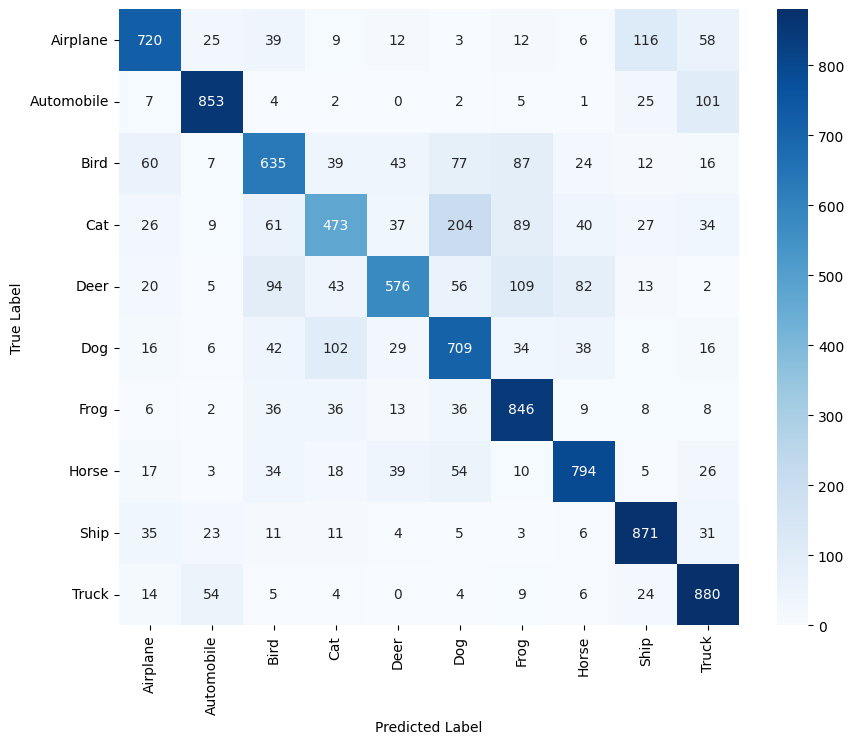

In [ ]:
# Load the saved model
simplecnn_final_model = load_model("/content/simple_cnn_final_model.keras")

# Evaluate model
test_loss, test_acc = simplecnn_final_model.evaluate(x_test, y_test)
print("Test Accuracy:", test_acc)

# Predictions and classification report
y_pred = np.argmax(simplecnn_final_model.predict(x_test), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Custom-built ResNet50

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3971 - loss: 1.6001
Test Accuracy: 0.3986999988555908
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step
              precision    recall  f1-score   support

    Airplane       0.36      0.51      0.42      1000
  Automobile       0.49      0.57      0.53      1000
        Bird       0.30      0.42      0.35      1000
         Cat       0.29      0.26      0.28      1000
        Deer       0.37      0.14      0.21      1000
         Dog       0.39      0.39      0.39      1000
        Frog       0.58      0.53      0.55      1000
       Horse       0.54      0.51      0.52      1000
        Ship       0.35      0.45      0.40      1000
       Truck       0.33      0.21      0.26      1000

    accuracy                           0.40     10000
   macro avg       0.40      0.40      0.39     10000
weighted avg       0.40      0.40      0.39     10000



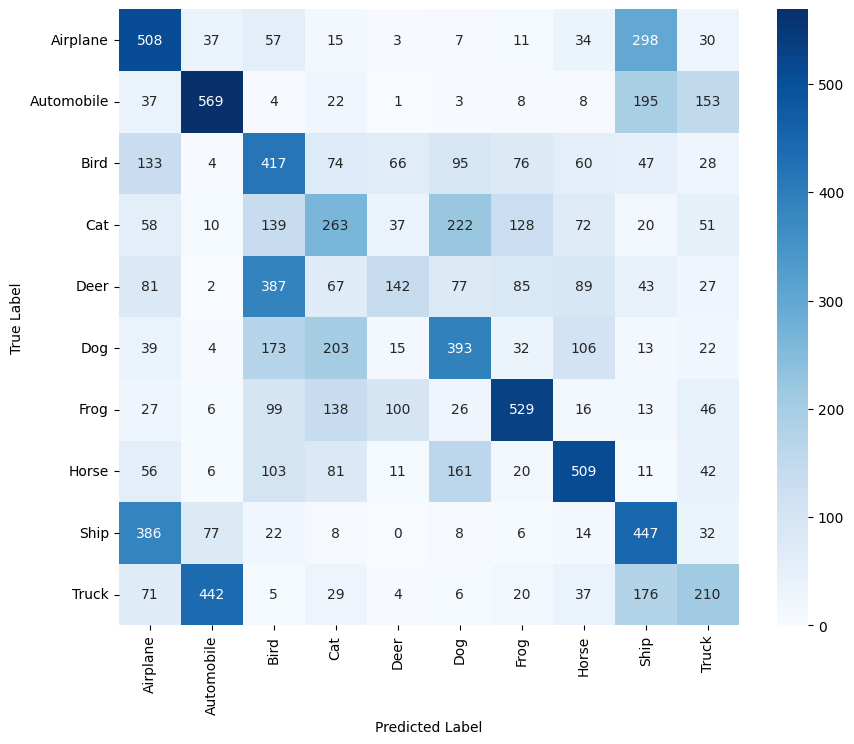

In [9]:
# Evaluate model
test_loss, test_acc = resnet50.evaluate(x_test, y_test)
print("Test Accuracy:", test_acc)

# Predictions and classification report
y_pred = np.argmax(resnet50.predict(x_test), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### DenseNet-121 (with Keras Tuner)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7810 - loss: 0.6981
Test Accuracy: 0.7771000266075134
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step
              precision    recall  f1-score   support

    Airplane       0.79      0.84      0.81      1000
  Automobile       0.87      0.85      0.86      1000
        Bird       0.72      0.74      0.73      1000
         Cat       0.62      0.64      0.63      1000
        Deer       0.81      0.69      0.75      1000
         Dog       0.79      0.56      0.65      1000
        Frog       0.82      0.81      0.82      1000
       Horse       0.73      0.89      0.80      1000
        Ship       0.84      0.90      0.87      1000
       Truck       0.80      0.87      0.83      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.77     10000
weighted avg       0.78      0.78      0.77     10000



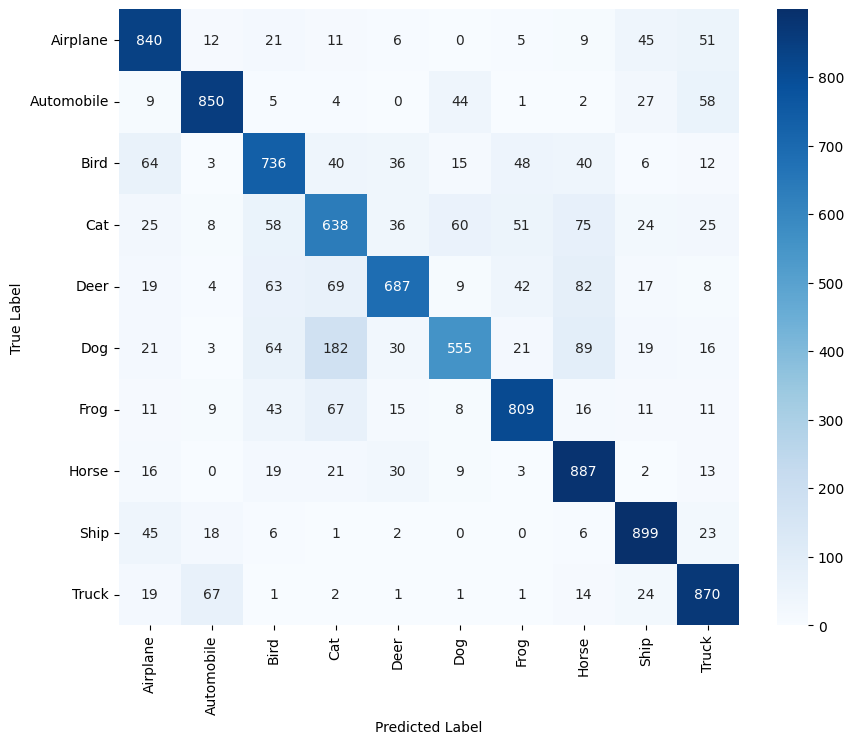

In [15]:
# Evaluate model
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_acc)

# Predictions and classification report
y_pred = np.argmax(model.predict(x_test), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Custom-built EfficientNet-B5

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3945 - loss: 1.6104
Test Accuracy: 0.39559999108314514
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step
              precision    recall  f1-score   support

    Airplane       0.40      0.39      0.40      1000
  Automobile       0.48      0.47      0.47      1000
        Bird       0.36      0.02      0.04      1000
         Cat       0.27      0.39      0.32      1000
        Deer       0.41      0.29      0.34      1000
         Dog       0.46      0.34      0.39      1000
        Frog       0.45      0.48      0.47      1000
       Horse       0.50      0.46      0.48      1000
        Ship       0.44      0.66      0.53      1000
       Truck       0.29      0.46      0.35      1000

    accuracy                           0.40     10000
   macro avg       0.40      0.40      0.38     10000
weighted avg       0.40      0.40      0.38     10000



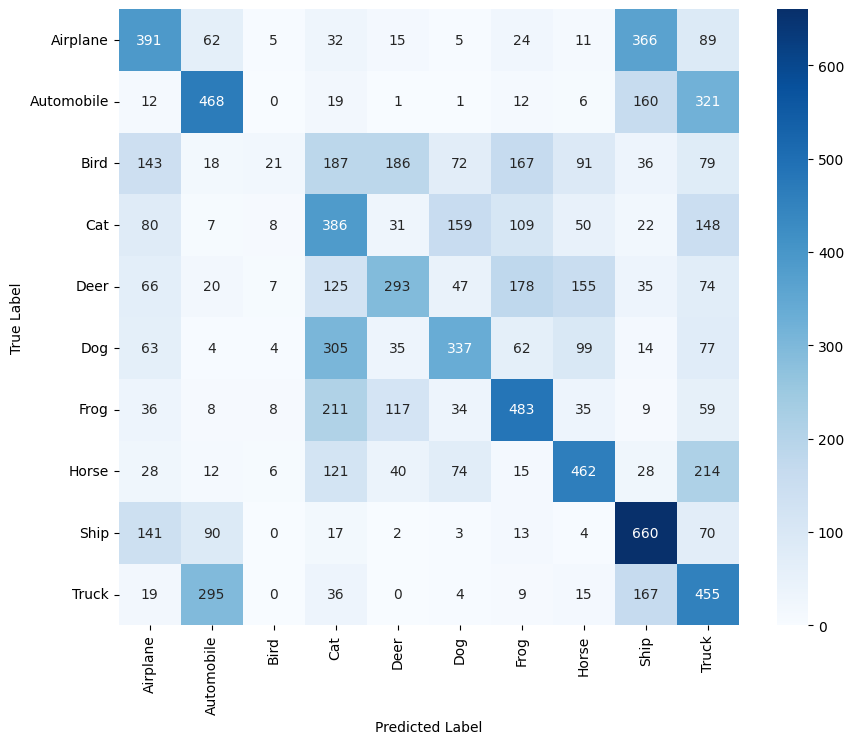

In [ ]:
# Evaluate model
test_loss, test_acc = efficientnet_b5.evaluate(x_test, y_test)
print("Test Accuracy:", test_acc)

# Predictions and classification report
y_pred = np.argmax(efficientnet_b5.predict(x_test), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()